In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

In [3]:
def GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,mu,sigma,S_0):    
    
    # Fixing random seed
    np.random.seed(1)
        
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
        
    X[:,0] = np.log(S_0)
    
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            
        X[:,i+1] = X[:,i] + (mu - 0.5 * sigma **2 ) * dt + sigma * np.power(dt, 0.5)*Z[:,i]
        time[i+1] = time[i] +dt
        
    #Compute exponent of ABM
    S = np.exp(X)
    paths = {"time":time,"X":X,"S":S}
    return paths

def DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0):
    Paths = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,mu,sigma_R,S_0)
    timeGrid = Paths["time"]
    X = Paths["X"]
    S = Paths["S"]

    d1 = np.zeros([NoOfPaths, NoOfSteps+1])
    d2 = np.zeros([NoOfPaths, NoOfSteps+1])
    Delta = np.zeros([NoOfPaths, NoOfSteps+1])
    Option = np.zeros([NoOfPaths, NoOfSteps+1])
    Cashflow = np.zeros([NoOfPaths, NoOfSteps+1])
    Balance = np.zeros([NoOfPaths, NoOfSteps+1])
    HE = np.zeros([NoOfPaths, NoOfSteps+1])

    dt = T/NoOfSteps
    for i in range(0,NoOfSteps+1):
        T_remaining = T - i*dt
        if i != NoOfSteps:
            d1[:,i] = (np.log(S[:,i] / K) + (r + 0.5 * sigma_H**2) * T_remaining) / (sigma_H * np.sqrt(T_remaining))
            d2[:,i] = d1[:,i] - sigma_H * np.sqrt(T_remaining)
            Delta[:,i] = si.norm.cdf(d1[:,i])
            Option[:,i] = S[:,i] * si.norm.cdf(d1[:,i]) - K * np.exp(-r * T_remaining) * si.norm.cdf(d2[:,i])
        else:
            d1[:,i] = np.nan
            d2[:,i] = np.nan
            Delta[:,i] = np.where(S[:,i] >= K, 1, 0)
            Option[:,i] = np.where(S[:,i] >= K, S[:,i]-K, 0)

        if i == 0:
            Cashflow[:,i] = 0
            Balance[:,i] = -Option[:,i] + S[:,i]*Delta[:,i]
        else:
            Cashflow[:,i] = (Delta[:,i] - Delta[:,i-1])*S[:,i]
            Balance[:,i] = Balance[:,i-1]*np.exp(r*dt)+Cashflow[:,i]
        HE[:,i] = -Option[:,i] + S[:,i]*Delta[:,i] - Balance[:,i]

    return S, d1, d2, Delta, Option, Cashflow, Balance, HE

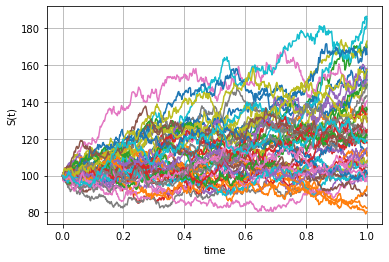

In [4]:
NoOfPaths = 10000
NoOfSteps = 500

S_0 = 100
K = 100
T = 1
mu = 0.2
r = 0.05
sigma_R = 0.2
sigma_H = 0.2

Paths = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,mu,sigma_R,S_0)
timeGrid = Paths["time"]
X = Paths["X"]
S = Paths["S"]

plt.figure(2)
plt.plot(timeGrid, np.transpose(S[:50,:]))   
plt.grid()
plt.xlabel("time")
plt.ylabel("S(t)")
plt.show()

NoOfSteps: 21, mu: 0.0, r: 0.0, sigma_R: 0.2, sigma_H: 0.2
Mean: 0.00397, Std: 0.42360
NoOfSteps: 84, mu: 0.0, r: 0.0, sigma_R: 0.2, sigma_H: 0.2
Mean: 0.00008, Std: 0.21946


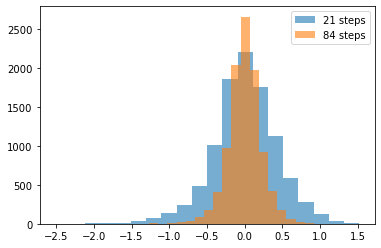

In [5]:
NoOfPaths = 10000
NoOfSteps = 21

S_0 = 100
K = 100
T = 21/252
mu = 0.00
r = 0.00
sigma_R = 0.2
sigma_H = 0.2

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="21 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

NoOfSteps = 84

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="84 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

plt.legend()
plt.show()

NoOfSteps: 21, mu: 0.0, r: 0.0, sigma_R: 0.2, sigma_H: 0.4
Mean: 2.29021, Std: 0.71903
NoOfSteps: 84, mu: 0.0, r: 0.0, sigma_R: 0.2, sigma_H: 0.4
Mean: 2.29304, Std: 0.61483


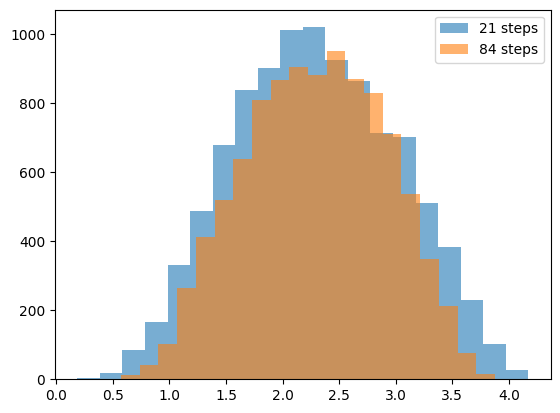

In [5]:
NoOfPaths = 10000
NoOfSteps = 21

S_0 = 100
K = 100
T = 21/252
mu = 0.00
r = 0.00
sigma_R = 0.2
sigma_H = 0.4

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="21 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

NoOfSteps = 84

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="84 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

plt.legend()
plt.show()

NoOfSteps: 21, mu: 0.2, r: 0.0, sigma_R: 0.2, sigma_H: 0.2
Mean: -0.00431, Std: 0.42174
NoOfSteps: 84, mu: 0.2, r: 0.0, sigma_R: 0.2, sigma_H: 0.2
Mean: -0.00056, Std: 0.21479


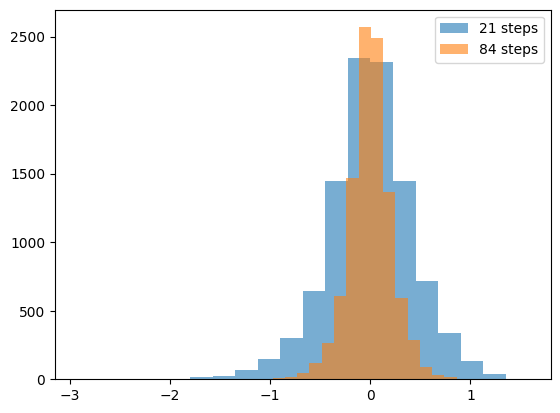

In [6]:
NoOfPaths = 10000
NoOfSteps = 21

S_0 = 100
K = 100
T = 21/252
mu = 0.20
r = 0.00
sigma_R = 0.2
sigma_H = 0.2

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="21 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

NoOfSteps = 84

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="84 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

plt.legend()
plt.show()

NoOfSteps: 21, mu: 0.2, r: 0.0, sigma_R: 0.2, sigma_H: 0.4
Mean: 2.27108, Std: 0.71877
NoOfSteps: 84, mu: 0.2, r: 0.0, sigma_R: 0.2, sigma_H: 0.4
Mean: 2.27774, Std: 0.61612


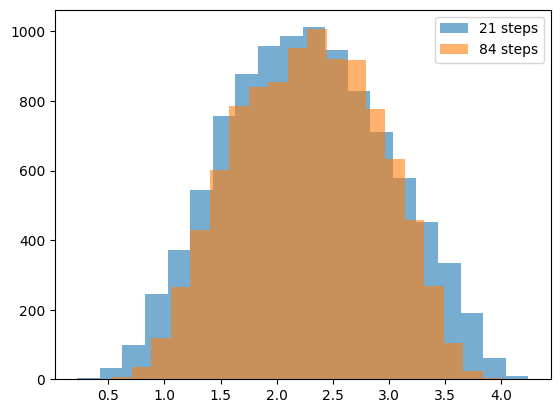

In [7]:
NoOfPaths = 10000
NoOfSteps = 21

S_0 = 100
K = 100
T = 21/252
mu = 0.20
r = 0.00
sigma_R = 0.2
sigma_H = 0.4

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="21 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

NoOfSteps = 84

S, d1, d2, Delta, Option, Cashflow, Balance, HE = DiscreteHedgingError(NoOfPaths,NoOfSteps,T,mu,r,sigma_R, sigma_H,S_0)
HE_last = HE[:,-1]
plt.hist(HE_last, bins=20, alpha=0.6, label="84 steps")
print(f"NoOfSteps: {NoOfSteps}, mu: {mu}, r: {r}, sigma_R: {sigma_R}, sigma_H: {sigma_H}")
print(f"Mean: {HE_last.mean():.5f}, Std: {HE_last.std():.5f}")

plt.legend()
plt.show()

In [8]:
num = 0

df = pd.DataFrame([S[num,:], d1[num,:], d2[num,:], Delta[num,:], Option[num,:], Cashflow[num,:], Balance[num,:], HE[num,:]]).T
df.columns = ["S", "d1", "d2", "Delta", "Option", "Cashflow", "Balance", "HedgingError"]
df

,S,d1,d2,Delta,Option,Cashflow,Balance,HedgingError
0,100.000000,0.057735,-0.057735,0.523020,4.604031,0.000000,47.697985,0.000000
1,101.060234,0.149275,0.034494,0.559332,5.150339,3.669633,51.367618,0.008216
2,100.695033,0.117754,0.003667,0.546869,4.920676,-1.254940,50.112678,0.033610
3,100.384579,0.090546,-0.022843,0.536073,4.724733,-1.083681,49.028997,0.059775
4,99.722744,0.031705,-0.080982,0.512647,4.349696,-2.336196,46.692801,0.080020
...,...,...,...,...,...,...,...,...
80,103.979932,1.561464,1.536266,0.940793,4.047229,5.330980,91.327449,2.448896
81,103.847600,1.741028,1.719206,0.959161,3.885375,1.907457,93.234907,2.486253
82,103.736423,2.067743,2.049925,0.980668,3.749565,2.231080,95.465987,2.515426
83,103.860736,3.012990,3.000391,0.998707,3.861215,1.873511,97.339497,2.525686
